In [53]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [54]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [55]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [56]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"

engine = create_engine(f"sqlite:///{database_path}")

In [57]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)


In [58]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [59]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [60]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [61]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [62]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

temps = calc_temps('2017-08-01', '2017-08-07')


print(temps)

min_temp = temps[0][0]
avg_temp = temps[0][1]
max_temp = temps[0][2]


[(72.0, 79.25, 83.0)]


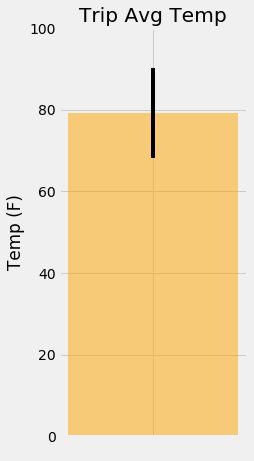

In [63]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(1,1, figsize=(3,7))

ax.bar(x=' ', height=avg_temp, yerr=(max_temp - min_temp), width=0.5, facecolor = 'orange', alpha = 0.5)

ax.set(
    title = 'Trip Avg Temp',
    ylim= (0,100),
    ylabel = 'Temp (F)'
)

plt.show()

### Daily Rainfall Average

In [64]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2017-08-07'
sel = [func.sum(Measurement.prcp), Station.name, Station.station, Station.latitude, Station.longitude, Station.elevation]

results = session.query(*sel).filter(Measurement.station == Station.station).filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
results


[(0.36,
  'MANOA LYON ARBO 785.2, HI US',
  'USC00516128',
  21.3331,
  -157.8025,
  152.4),
 (0.22,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  21.5213,
  -157.8374,
  7.0),
 (0.06,
  'WAIHEE 837.5, HI US',
  'USC00519281',
  21.45167,
  -157.84888999999998,
  32.9),
 (0.04, 'WAIKIKI 717.2, HI US', 'USC00519397', 21.2716, -157.8168, 3.0),
 (0.0,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  'USC00519523',
  21.33556,
  -157.71139,
  19.5)]

### Daily Temperature Normals

In [65]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [66]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []
dates = []
for x in range(1,8):
    norm = daily_normals(f"08-0{x}")
    dates.append(f"08-0{x}")
    normals.append(norm[0])
print(normals)
print(dates)

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates


# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]
['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']


In [67]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame({'date':[],
                               'min_temp': [],
                               'avg_temp': [],
                               'max_temp': []})

for x in range(len(normals)):
    daily_norms_df = daily_norms_df.append({'date': dates[x],
                                            'min_temp': normals[x][0],
                                            'avg_temp': normals[x][1],
                                            'max_temp': normals[x][2]},
                                            ignore_index=True)

daily_norms_df = daily_norms_df.set_index('date')

daily_norms_df

,min_temp,avg_temp,max_temp
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


Text(0.5, 1.0, 'Daily Normal Temperatures for 08-01 thru 08-07')

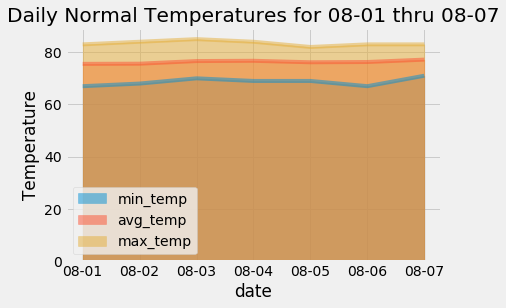

In [68]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', stacked=False)
plt.ylabel('Temperature')
plt.title('Daily Normal Temperatures for 08-01 thru 08-07')

## Close Session

In [69]:
session.close()